<a href="https://colab.research.google.com/github/Wnjoki/yuYpOTrvBrzkHSgq-MonReader/blob/main/MonReader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Image Classification Using Tensorflow

Import Libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image

import os
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Load the Images

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#paths to the training and testing sets
base_dir = '/content/drive/MyDrive/Colab Notebooks/images'
train_dir = os.path.join(base_dir, 'training')
test_dir = os.path.join(base_dir, 'testing')

In [ ]:
os.listdir(base_dir)

['training', 'testing']

Create Tensorflow datasets

We use `image_dataset_from_directory` as it will infer the classes from the folder.


When using the function to generate the dataset, you will need to define the following parameters:

-The path to the data
an optional seed for shuffling and transformations
-The `image_size` is the size the images will be resized to after being loaded from the disk
-`batch_size`  images will be loaded in batches
In the absence of a validation set, you can also define a `validation_split`. If it is set, the `subset` also needs to be passed. That is to indicate whether the split is a validation or training split.

In [ ]:
training_set = tf.keras.preprocessing.image_dataset_from_directory(
train_dir,
seed=101,
image_size=(224, 224),
batch_size=32)

Found 2392 files belonging to 2 classes.


In [ ]:
class_names = training_set.class_names

class_names

['flip', 'notflip']

In [ ]:
validation_set = tf.keras.preprocessing.image_dataset_from_directory(
test_dir,
seed=101,
image_size=(224, 224),
batch_size=32)

Found 597 files belonging to 2 classes.


#Data augmentation

Data augmentation is  applied in order to prevent overfitting. Augmenting the images increases the dataset as well as exposes the model to various aspects of the data. Augmentation can be achieved by applying random transformations such as flipping and rotating the images.

In [ ]:
data_augmentation = keras.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(224, 224,3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
  ]
)


#Model Definition

In [ ]:
model = Sequential([
    data_augmentation,
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    Conv2D(filters=32,kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(filters=64,kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),


    Conv2D(filters=128,kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),


    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

Visualize the model

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                  

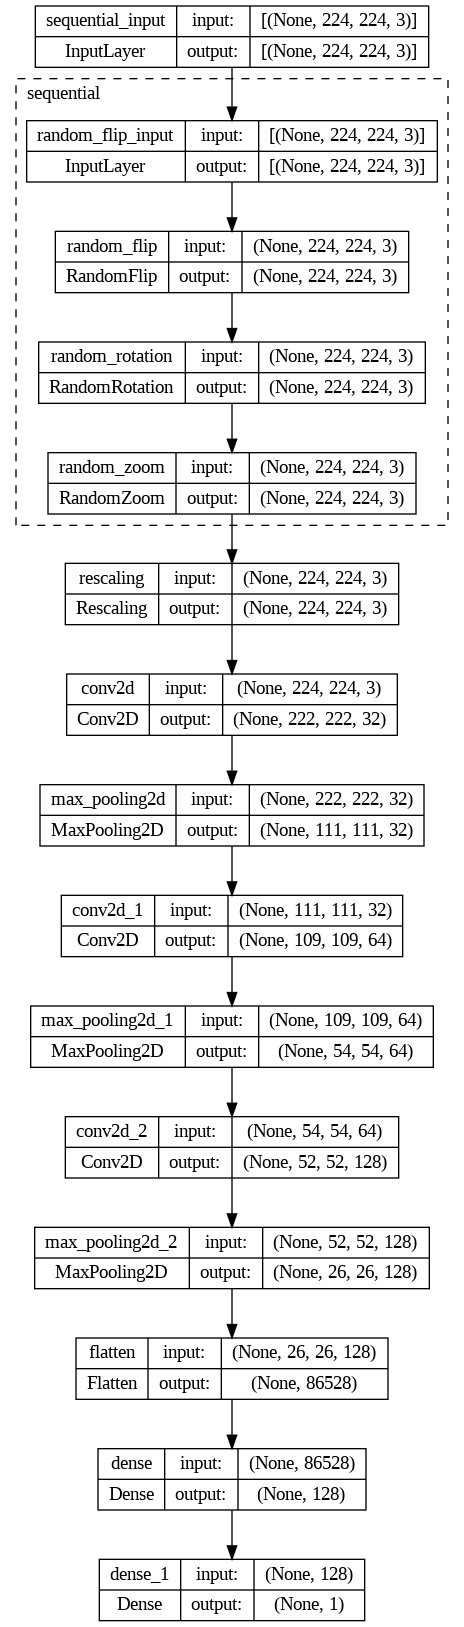

In [ ]:
#Plot the model
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

#Compiling the model

In [ ]:
model.compile(optimizer='adam',
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

In [ ]:
from tensorflow.keras import backend as K


def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    actual_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (actual_positives + K.epsilon())
    return recall


def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_m])

In [ ]:
#define callbacks
callbacks = [
             EarlyStopping(patience=2)
]

Early stopping helps to avoid overfitting on training data as it stops the training when the model stops improving.



#Training the Model

In [ ]:
history = model.fit(training_set,validation_data=validation_set, epochs=10,callbacks=callbacks)

Epoch 1/10
75/75 [==============================] - 392s 4s/step - loss: 0.7202 - accuracy: 0.5059 - f1_m: 0.3747 - val_loss: 0.6927 - val_accuracy: 0.5561 - val_f1_m: 0.5436
Epoch 2/10
75/75 [==============================] - 33s 383ms/step - loss: 0.6922 - accuracy: 0.5050 - f1_m: 0.5033 - val_loss: 0.6929 - val_accuracy: 0.5477 - val_f1_m: 0.6494
Epoch 3/10
75/75 [==============================] - 31s 384ms/step - loss: 0.6922 - accuracy: 0.5134 - f1_m: 0.4769 - val_loss: 0.6929 - val_accuracy: 0.5042 - val_f1_m: 0.1044


#Monitoring the model’s performance

In [ ]:
#obtain the training losses and accuracies
metrics_df = pd.DataFrame(history.history)
metrics_df

,loss,accuracy,f1_m,val_loss,val_accuracy,val_f1_m
0,0.720209,0.505853,0.374722,0.692657,0.556114,0.543649
1,0.692227,0.505017,0.503304,0.692859,0.547739,0.649403
2,0.692224,0.513378,0.476851,0.692894,0.504188,0.104360


Traning and Validation Loss


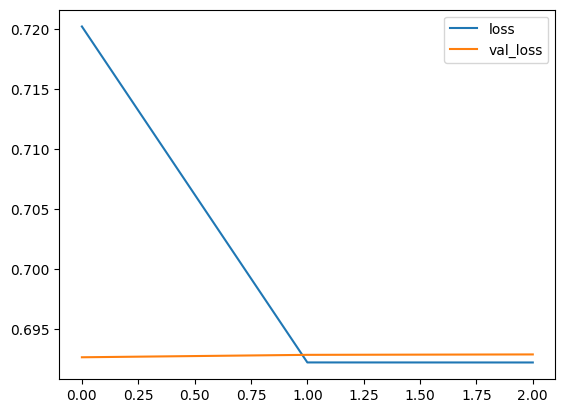

In [ ]:
#plot the metrics
print("Traning and Validation Loss")
metrics_df[["loss","val_loss"]].plot();

Traning and Validation Accuracy


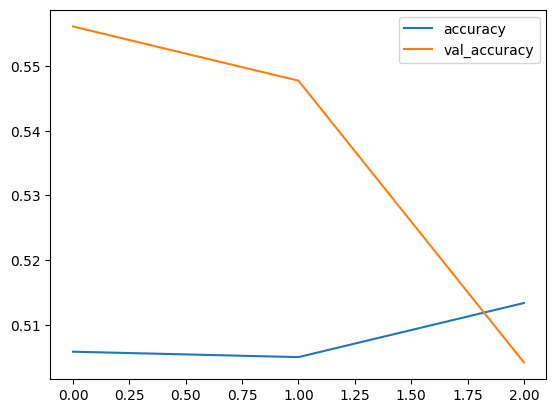

In [ ]:
print("Traning and Validation Accuracy")
metrics_df[["accuracy","val_accuracy"]].plot();

Traning and Validation f1 score


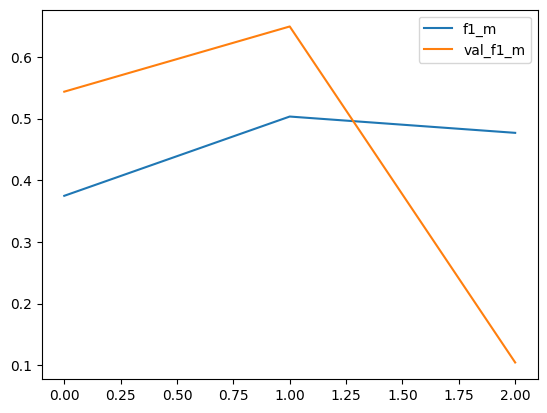

In [ ]:
print("Traning and Validation f1 score")
metrics_df[["f1_m","val_f1_m"]].plot();

The F1 score is an important metric as it considers both the precision and recall of our model's predictions. In this case, achieving  F1 score of 72.5% on training dataset and 74.21% on validation dataset indicates that our model has successfully managed to find a balance between accurately identifying positive cases (precision) and capturing all relevant positive cases (recall).

 Our F1 score reflects the effectiveness of our model in making accurate and comprehensive predictions, giving us confidence in its suitability for real-world applications."







#Model Evaluation

In [ ]:
results = model.evaluate(validation_set)
loss = results[0]
accuracy = results[1]
print(f'Loss on test dataset: {loss:.2f}')
print(f'Accuracy on test dataset: {accuracy * 100:.2f}%')

19/19 [==============================] - 6s 172ms/step - loss: 0.6929 - accuracy: 0.5042 - f1_m: 0.1006
Loss on test dataset: 0.69
Accuracy on test dataset: 50.42%


#Model Predictions
Predict if the page is being flipped using a single image.

In [ ]:
prediction = model.predict(validation_set)


19/19 [==============================] - 7s 160ms/step


In [ ]:
prediction[0][0]

0.49041584

The output of this network is a number between 0 and 1. That number represents the probability that the image belongs to class 1. Class 1 in this case is  not flip.Set a threshold of say 50% to separate the two classes.

In [ ]:
if prediction[0][0]>0.5:
  print(" Image is being flipped")
else:
   print(" Image is a not flipped")

 Image is a not flipped


#Bonus

Predict if a given sequence of images contains an action of flipping.

In [ ]:
import cv2
import numpy as np

# Define parameters for image resizing
target_size=(224, 224)

# Load and preprocess a sequence of images
def load_and_preprocess_images(image_paths):
    images = []

    for image_path in image_paths:
        image = cv2.imread(image_path)  # Load the image using OpenCV
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        image = cv2.resize(image, (target_size))  # Resize the image
        image = image / 255.0  # Normalize images values to [0, 1]
        images.append(image)

    return np.array(images)





In [ ]:
# Define paths to the subdirectories
data_dir = test_dir
class_names = ['flip', 'notflip']

# Create an empty list to store image paths
sequence_image_paths = []

# Loop through each class
for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    class_filenames = os.listdir(class_dir)
    class_image_paths = [os.path.join(class_dir, filename) for filename in class_filenames]
    sequence_image_paths.extend(class_image_paths)

# Load and preprocess the images
preprocessed_sequence = load_and_preprocess_images(sequence_image_paths)


19/19 [==============================] - 0s 19ms/step


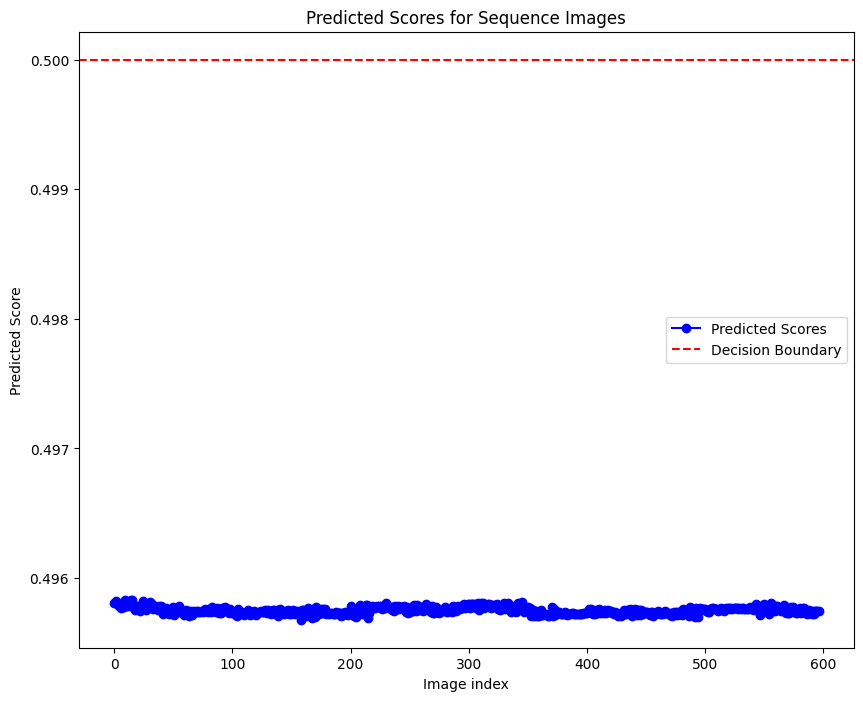

In [ ]:
import matplotlib.pyplot as plt

# Pass the image through the model and get the prediction
predicted_scores = model.predict(preprocessed_sequence)

# Create a figure
plt.figure(figsize=(10, 8))

# Plot the predicted scores
plt.plot(predicted_scores, marker='o', linestyle='-', color='b', label='Predicted Scores')

# Add a horizontal line at 0.5 (decision boundary)
plt.axhline(y=0.5, color='r', linestyle='--', label='Decision Boundary')

# Labels and legend
plt.title('Predicted Scores for Sequence Images')
plt.xlabel('Image index')
plt.ylabel('Predicted Score')
plt.legend()

# Show the plot
plt.show()


#Image Classification Using Pytorch

Import libraries

In [2]:

import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt


In [3]:
# Define relevant variables for the ML task
batch_size = 32
num_classes = 2
learning_rate = 0.001
num_epochs = 10

In [4]:
# Device will determine whether to run the training on GPU or CPU.
device = 'cuda'

**Load the Data**

The data to train our model has images and labels attached to it.
It is stored into training and testing folders that consist of images labelled as flip and not flip.



In [5]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#train and test data directory
train_data_dir = "/content/drive/MyDrive/Colab Notebooks/images/training"
test_data_dir = "/content/drive/MyDrive/Colab Notebooks/images/testing"


In [7]:

#load the train and test data
transform = transforms.Compose([transforms.Resize((224,224)),
                                     transforms.ToTensor(),
                                     #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                     ])
train_dataset = ImageFolder(train_data_dir,transform)
test_dataset = ImageFolder(test_data_dir,transform)

img, label = train_dataset[0]
print(img.shape,label)

torch.Size([3, 224, 224]) 0


In [8]:
#load the train and test into batches.
train_loader = DataLoader(train_dataset, batch_size=32, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle = True)

In the cell above, torchvision.transforms module preprocess the images,  first  resize the image for (224*224) shape and then transforms them into tensors.

The first image in the train_dataset has a shape (3, 224, 224) which means the image has 3 channels (RGB), height 224, and width 224. The image has a label 0, which represents the “flip” class

**Exploring Images :**

To visualize images of a single batch, use make_grid() from torchvision utilities. It gives an overall view of images in batch in the form of an image grid.

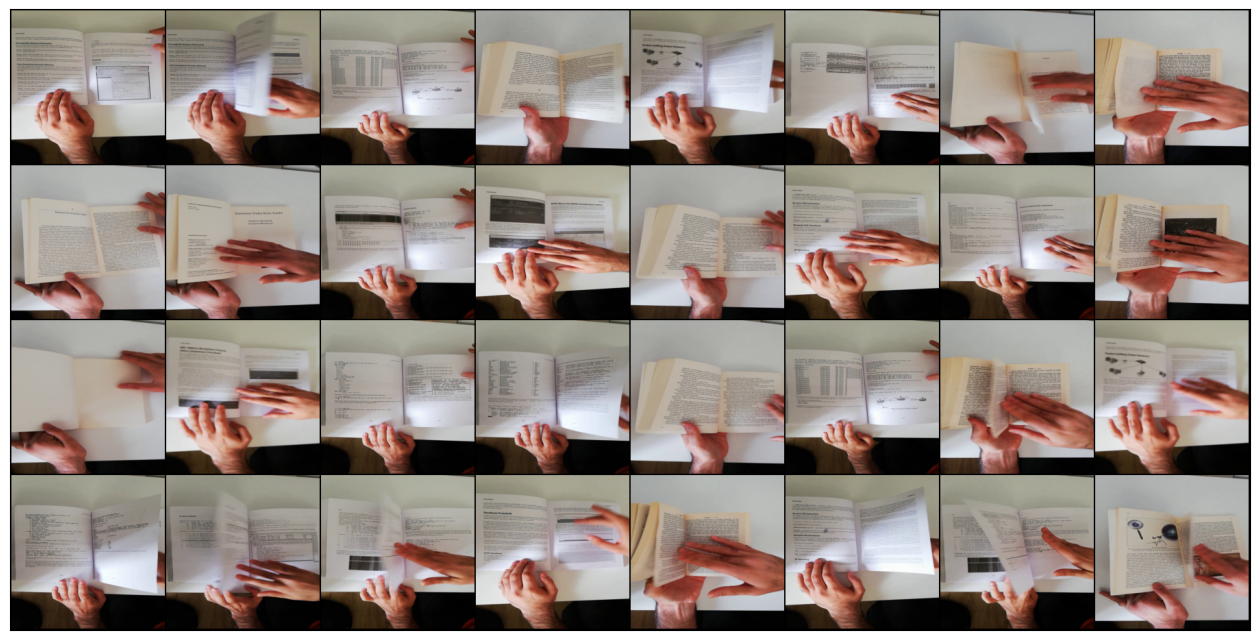

In [9]:
def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=8).permute(1,2,0))
        break

show_batch(train_loader)


Label : flip


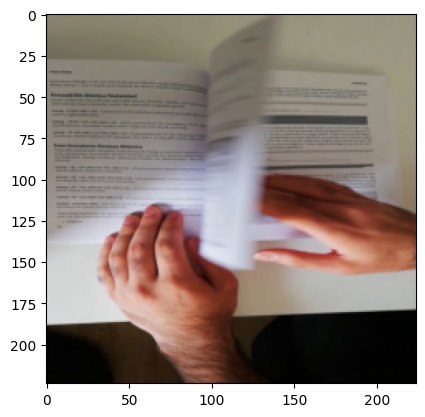

In [10]:
def display_img(img,label):
    print(f"Label : {test_dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))

display_img(*test_dataset[0])

The first images in both the train and test datasets are of flip class

**Architecture of the network**

In [35]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),)


        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),)

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),)


        self.fc1 = nn.Linear(107648 , 512)
        self.fc2 = nn.Linear(512, num_classes)



    # Inside the forward method
    def forward(self, x):
      out = F.relu(self.layer1(x))
      out = F.relu(self.layer2(out))
      out = F.relu(self.layer3(out))
      out = out.view(out.size(0), -1) # Flatten and then pass through fc1
      out = F.relu(self.fc1(out))
      out = self.fc2(out)
      return out

#Setting Hyperparameters

In [36]:
# instantiate CNN model
model = NeuralNetwork().to(device)
model

NeuralNetwork(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=107648, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [37]:
#cost function and the algorithm for optimization
learning_rate = 0.001
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
total_step = len(train_loader)

Hyperparameters


We start by initializing our model with the number of classes. We then choose cross-entropy and Adam as our loss function and optimizer respectively.  We also define the variable total_step to make iteration through various batches easier.

Display of network parameters for each layer


*   Weight
Bias

*   Bias






In [38]:
#Display of network parameters for each layer
for name, param in model.state_dict().items():
  print(name, param.shape)


layer1.0.weight torch.Size([32, 3, 3, 3])
layer1.0.bias torch.Size([32])
layer2.0.weight torch.Size([64, 32, 3, 3])
layer2.0.bias torch.Size([64])
layer3.0.weight torch.Size([128, 64, 3, 3])
layer3.0.bias torch.Size([128])
fc1.weight torch.Size([512, 107648])
fc1.bias torch.Size([512])
fc2.weight torch.Size([2, 512])
fc2.bias torch.Size([2])


#**Model Training**

In [39]:
# We use the pre-defined number of epochs to determine how many iterations to train the network on
for epoch in range(num_epochs):
  model.train()
	#Load in the data in batches using the train_loader object
  for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))





Epoch [1/10], Loss: 0.5906
Epoch [2/10], Loss: 0.3114
Epoch [3/10], Loss: 0.0494
Epoch [4/10], Loss: 0.0093
Epoch [5/10], Loss: 0.0157
Epoch [6/10], Loss: 0.0039
Epoch [7/10], Loss: 0.0183
Epoch [8/10], Loss: 0.0405
Epoch [9/10], Loss: 0.0047
Epoch [10/10], Loss: 0.0002


In [40]:
PATH = './convnet.pth'
torch.save(model.state_dict(), PATH)

# Model Evaluation

In [41]:
model.eval()
with torch.no_grad(): # very important
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(2)]
    n_class_samples = [0 for i in range(2)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()



print('Accuracy of the network on the test images: {} %'.format(100 * n_correct / n_samples))

Accuracy of the network on the test images: 98.49246231155779 %


In [42]:
print(f"Length of labels: {len(labels)}")
print(f"Length of predicted: {len(predicted)}")

Length of labels: 21
Length of predicted: 21


In [43]:
classes = ('flip', 'not flip')

for i in range(len(labels)):
            label = labels[i].item()
            pred = predicted[i].item()

            if label == pred:
                n_class_correct[label] += 1
            n_class_samples[label] += 1

for i in range(len(classes)):
    acc = 100.0 * n_class_correct[i] / n_class_samples[i]
    print(f'Accuracy of {classes[i]}: {acc:.2f} %')

Accuracy of flip: 100.00 %
Accuracy of not flip: 100.00 %


#Hyperpameter Tuning

In [44]:
learning_rates = [0.1, 0.01, 0.001]
batch_sizes = [16, 32, 64]
num_epochs = 10
accuracy = n_correct / n_samples
best_accuracy = 0.0
best_params = {}

# Hyperparameter tuning loop
for lr in learning_rates:
    for batch_size in batch_sizes:
        model = NeuralNetwork()
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        for epoch in range(num_epochs):
            model.train()
            for batch_idx, (images, labels) in enumerate(train_loader):
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        # Evaluate on validation set
        model.eval()
        with torch.no_grad(): # very important
          n_correct = 0
          n_samples = 0
          n_class_correct = [0 for i in range(2)]
          n_class_samples = [0 for i in range(2)]
          for images, labels in test_loader:
              images = images.to(device)
              labels = labels.to(device)
              outputs = model(images)
        # max returns (value ,index)
              _, predicted = torch.max(outputs, 1)
              n_samples += labels.size(0)
              n_correct += (predicted == labels).sum().item()
        # ... Load validation data and evaluate accuracy ...

        # Keep track of the best hyperparameters
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {'learning_rate': lr, 'batch_size': batch_size}

print("Best hyperparameters:", best_params)

RuntimeError: ignored

In [ ]:
from sklearn.metrics import f1_score


f1 = f1_score(labels, predicted, average='weighted')
print(f"F1 Score: {f1:.4f}")

#Vision Transformer

Use Of Vit Pytorch

Libraries

In [2]:
!pip install linformer
!pip install vit_pytorch
!pip install transformers
!pip install vit_keras
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 630.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 5.5 MB/s eta 0:00:00


In [3]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from PIL import Image
from torchvision import transforms
from transformers import ViTFeatureExtractor, ViTForImageClassification
import torch
#
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from vit_keras import vit
import tensorflow as tf

import tensorflow_hub as hub
#  3
import torch.nn as nn
import torch.optim as optim
from linformer import Linformer
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
from vit_pytorch.efficient import ViT
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, precision_score, recall_score

import torchvision
from torchvision.transforms import ToTensor

from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder


# Warnings
import warnings


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("CUDA-enabled PyTorch: ", torch.cuda.is_available())


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Num GPUs Available:  0
CUDA-enabled PyTorch:  False


In [4]:
# Suppress deprecation warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)


Hyperparameter

In [5]:

# Hyperparameters:
batch_size = 32
num_epochs = 10
lr = 3e-5
gamma = 0.7
seed = 142
IMG_SIZE = 128
patch_size = 16
num_classes = 2

**Tensor Transforms & Data Loaders**

In [6]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

#train and test data directory
train_data_dir = "/content/drive/MyDrive/Colab Notebooks/images/training"
test_data_dir = "/content/drive/MyDrive/Colab Notebooks/images/testing"

Mounted at /content/drive


In [7]:
# Tensor Transforms (with Augmentation) and Pytorch Preprocessing:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

#load the train and test data
train_ds = ImageFolder(train_data_dir,transform=transform)
test_ds = ImageFolder(test_data_dir,transform=transform)


# Create data loaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)




In [9]:
!pip install torch torchvision torchaudio

**Model Building**

In [8]:
# Training device:
device = 'cpu'

# Linear Transformer:
efficient_transformer = Linformer(dim=128, seq_len=64+1, depth=12, heads=8, k=64)

# Vision Transformer Model:
model = ViT(dim=128, image_size=224, patch_size=patch_size, num_classes=num_classes, transformer=efficient_transformer, channels=3).to(device)

# loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

# Learning Rate Scheduler for Optimizer:
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

**Model Compile and Training**

In [9]:
# Compile
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=gamma)

In [1]:
# Training
epoch_losses = []
test_losses = []
test_accuracies = []
test_precisions = []
test_recalls = []

for epoch in range(num_epochs):
  model.train()
  epoch_loss = 0
  epoch_accuracy = 0

  for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        #forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

         #Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #train loss and accuracy for the epoch
        acc = (outputs.argmax(dim=1) == labels).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

        # model evaluation and calculate metrics
        model.eval()
        test_accuracy = 0.0
        test_loss = 0.0
        all_labels = []
        all_predictions = []

  with torch.no_grad():
      for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            val_output = model(images)
            val_loss = criterion(val_output, labels)
            test_loss += val_loss.item()
            _, predicted = val_output.max(1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

  test_loss = test_loss / len(test_loader)
  test_accuracy = 100 * sum(np.array(all_predictions) == np.array(all_labels)) / len(all_labels)
  precision = precision_score(all_labels, all_predictions)
  recall = recall_score(all_labels, all_predictions)

        #  metrics for plotting
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)
  test_precisions.append(precision)
  test_recalls.append(recall)


  print(f"Epoch [{epoch+1}/{num_epochs}] | Train loss : {epoch_loss:.4f} | Accuracy: {epoch_accuracy:.4f} | Test_loss : {test_loss:.4f} | Test Accuracy: {test_accuracy:.2f}%")



NameError: ignored

Model Saving

In [ ]:
# Save Model:
PATH = "epochs"+"_"+str(num_epochs)+"_"+"img"+"_"+str(IMG_SIZE)+"_"+"patch"+"_"+str(patch_size)+"_"+"lr"+"_"+str(lr)+".pt"
torch.save(model.state_dict(), PATH)

In [ ]:
# load saved model:
PATH = "epochs"+"_"+str(num_epochs)+"_"+"img"+"_"+str(IMG_SIZE)+"_"+"patch"+"_"+str(patch_size)+"_"+"lr"+"_"+str(lr)+".pt"
#efficient_transformer = Linformer(dim=128, seq_len=49+1, depth=12, heads=8, k=64)
#model = ViT(image_size=224, patch_size=32, num_classes=2, dim=128 ,transformer=efficient_transformer, channels=3)
model.load_state_dict(torch.load(PATH))

Model Evaluation — Accuracy

In [ ]:
# Performance on Valid/Test Data
def overall_accuracy(model, test_loader, criterion):

    '''
    Model testing

    Args:
        model: model used during training and validation
        test_loader: data loader object containing testing data
        criterion: loss function used

    Returns:
        test_loss: calculated loss during testing
        accuracy: calculated accuracy during testing
        y_proba: predicted class probabilities
        y_truth: ground truth of testing data
    '''

    y_proba = []
    y_truth = []
    test_loss = 0
    total = 0
    correct = 0
    for data in tqdm(test_loader):
        X, y = data[0].to(device), data[1].to(device)
        output = model(X)
        test_loss += criterion(output, y.long()).item()
        for index, i in enumerate(output):
            y_proba.append(i[1])
            y_truth.append(y[index])
            if torch.argmax(i) == y[index]:
                correct+=1
            total+=1

    accuracy = correct/total

    y_proba_out = np.array([float(y_proba[i]) for i in range(len(y_proba))])
    y_truth_out = np.array([float(y_truth[i]) for i in range(len(y_truth))])

    return test_loss, accuracy, y_proba_out, y_truth_out


loss, acc, y_proba, y_truth = overall_accuracy(model, test_loader, criterion = nn.CrossEntropyLoss())


print(f"Accuracy: {acc}")

print(pd.value_counts(y_truth))

Model Evaluation — ROC Curve

In [ ]:
# Plot ROC curve:

def plot_ROCAUC_curve(y_truth, y_proba, fig_size):

    '''
    Plots the Receiver Operating Characteristic Curve (ROC) and displays Area Under the Curve (AUC) score.

    Args:
        y_truth: ground truth for testing data output
        y_proba: class probabilties predicted from model
        fig_size: size of the output pyplot figure

    Returns: void
    '''

    fpr, tpr, threshold = roc_curve(y_truth, y_proba)
    auc_score = roc_auc_score(y_truth, y_proba)
    txt_box = "AUC Score: " + str(round(auc_score, 4))
    plt.figure(figsize=fig_size)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1],'--')
    plt.annotate(txt_box, xy=(0.65, 0.05), xycoords='axes fraction')
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
#     plt.savefig('ROC.png')
plot_ROCAUC_curve(y_truth, y_proba, (8, 8))


Model Evaluation Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

net = model
# iterate over test data
for inputs, labels in test_loader:
        output = net(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('cats', 'dogs')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
# plt.savefig('cm.png')

Model Inference on New Images

In [ ]:
# Inference on Single Images (cats-dogs):
test_image = "new_cat_image.jpg"
test_image_null = "new_dog_image.png"
image = Image.open(test_image)
image_null = Image.open(test_image_null)

# Define tensor transform and apply it:
data_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
image_t = data_transform(image).unsqueeze(0)
image_null_t = data_transform(image_null).unsqueeze(0)

# Labels:
for inputs, labels in test_loader:
        labels = labels.data.cpu().numpy()

# Prediction:
out_cat = model(image_t)
out_dog= model(image_null_t)
print("predicted cat tensor:", out_cat)
print("predicted dog tensor:", out_dog)
print("")
# Print:
if(labels[out_cat.argmax()]== 0):
    print("smoke")
else:
    print("else")

# Show Image:
plt.figure(figsize=(2, 2))
plt.imshow(image)
plt.show()
# Print:
if(labels[out_dog.argmax()]== 0):
    print("cat")
else:
    print("dog")

# Show Image Null:
plt.figure(figsize=(2, 2))
plt.imshow(image_null)
plt.show()